Model using last 1 day(s): RMSE=848.631, MAE=591.063, R2=-0.619, BestParams={'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Model using last 2 day(s): RMSE=841.631, MAE=584.698, R2=-0.593, BestParams={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Model using last 3 day(s): RMSE=842.592, MAE=586.257, R2=-0.596, BestParams={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Model using last 4 day(s): RMSE=848.250, MAE=591.884, R2=-0.618, BestParams={'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Model using last 5 day(s): RMSE=844.021, MAE=589.043, R2=-0.602, BestParams={'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}


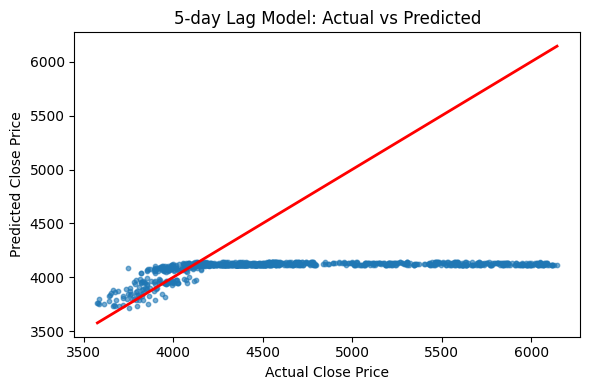

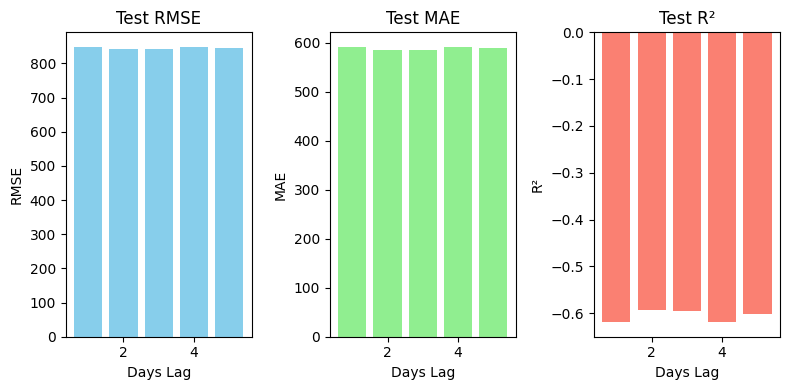

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data and compute technical indicators
df = pd.read_csv('final dataset for stock prediction.csv', parse_dates=['Date'])
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()

# Lag macroeconomic factors by 1 day
macro_cols = ['CPIAUCSL', 'GDP', 'FEDFUNDS', 'U2RATE']
for col in macro_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

results = []
# Train 5 models using 1-5 days of lagged features
for days in range(1, 6):
    df_i = df.copy()
    # Create lagged features for price and technical indicators
    for lag in range(1, days+1):
        df_i[f'Close_lag{lag}'] = df_i['Close'].shift(lag)
        df_i[f'RSI_lag{lag}'] = df_i['RSI'].shift(lag)
        df_i[f'MACD_lag{lag}'] = df_i['MACD'].shift(lag)
        df_i[f'MA7_lag{lag}'] = df_i['MA7'].shift(lag)
        df_i[f'MA21_lag{lag}'] = df_i['MA21'].shift(lag)
    # Define feature columns (price lags, indicator lags, macro lags)
    feature_cols = []
    feature_cols += [f'Close_lag{lag}' for lag in range(1, days+1)]
    feature_cols += [f'RSI_lag{lag}'   for lag in range(1, days+1)]
    feature_cols += [f'MACD_lag{lag}'  for lag in range(1, days+1)]
    feature_cols += [f'MA7_lag{lag}'   for lag in range(1, days+1)]
    feature_cols += [f'MA21_lag{lag}'  for lag in range(1, days+1)]
    feature_cols += [f'{col}_lag1' for col in macro_cols]
    # Drop rows with NaN in features or target
    df_i = df_i.dropna(subset=feature_cols + ['Close'])
    X = df_i[feature_cols].values
    y = df_i['Close'].values
    # 80-20 train-test split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    # Hyperparameter grid search
    rf = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_leaf': [1, 2]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_rf = grid.best_estimator_
    # Predict and evaluate
    y_pred = best_rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    results.append({'days': days, 'rmse': rmse, 'mae': mae, 'r2': r2})
    print(f"Model using last {days} day(s): RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}, BestParams={grid.best_params_}")

# Visualization: Actual vs Predicted for the 5-day model
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('5-day Lag Model: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Bar charts comparing metrics across the 5 models
days = [r['days'] for r in results]
rmse_vals = [r['rmse'] for r in results]
mae_vals  = [r['mae']  for r in results]
r2_vals   = [r['r2']   for r in results]
plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
plt.bar(days, rmse_vals, color='skyblue')
plt.xlabel('Days Lag')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.subplot(1,3,2)
plt.bar(days, mae_vals, color='lightgreen')
plt.xlabel('Days Lag')
plt.ylabel('MAE')
plt.title('Test MAE')
plt.subplot(1,3,3)
plt.bar(days, r2_vals, color='salmon')
plt.xlabel('Days Lag')
plt.ylabel('R\u00b2')
plt.title('Test R\u00b2')
plt.tight_layout()
plt.show()


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## Data Loading and Technical Indicator Computation

In [2]:
# Load data and compute technical indicators
df = pd.read_csv('final dataset for stock prediction.csv', parse_dates=['Date'])

# Compute RSI
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

# Compute MACD
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()

# Compute Moving Averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()

display(df.head())

,Date,Open,Close,Volume,CPIAUCSL,GDP,FEDFUNDS,U2RATE,RSI,MACD,MA7,MA21
0,2005-05-24,1193.859985,1194.069946,1681000000,193.6,12922.656,3.0,2.4,NaN,0.000000,NaN,NaN
1,2005-05-25,1194.069946,1190.010010,1742180000,193.6,12922.656,3.0,2.4,NaN,-0.323870,NaN,NaN
2,2005-05-26,1190.010010,1197.619995,1654110000,193.6,12922.656,3.0,2.4,NaN,0.033142,NaN,NaN
3,2005-05-27,1197.619995,1198.780029,1381430000,193.6,12922.656,3.0,2.4,NaN,0.405012,NaN,NaN
4,2005-05-31,1198.780029,1191.500000,1840680000,193.6,12922.656,3.0,2.4,NaN,0.111005,NaN,NaN


## Lagging Macroeconomic Factors

In [3]:
# Lag macroeconomic factors by 1 day
macro_cols = ['CPIAUCSL', 'GDP', 'FEDFUNDS', 'U2RATE']
for col in macro_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

display(df.head())

,Date,Open,Close,Volume,CPIAUCSL,GDP,FEDFUNDS,U2RATE,RSI,MACD,MA7,MA21,CPIAUCSL_lag1,GDP_lag1,FEDFUNDS_lag1,U2RATE_lag1
0,2005-05-24,1193.859985,1194.069946,1681000000,193.6,12922.656,3.0,2.4,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-05-25,1194.069946,1190.010010,1742180000,193.6,12922.656,3.0,2.4,NaN,-0.323870,NaN,NaN,193.6,12922.656,3.0,2.4
2,2005-05-26,1190.010010,1197.619995,1654110000,193.6,12922.656,3.0,2.4,NaN,0.033142,NaN,NaN,193.6,12922.656,3.0,2.4
3,2005-05-27,1197.619995,1198.780029,1381430000,193.6,12922.656,3.0,2.4,NaN,0.405012,NaN,NaN,193.6,12922.656,3.0,2.4
4,2005-05-31,1198.780029,1191.500000,1840680000,193.6,12922.656,3.0,2.4,NaN,0.111005,NaN,NaN,193.6,12922.656,3.0,2.4


## Model Training and Evaluation for Varying Lag Days
Train and evaluate Random Forest Regressor models using 1 to 5 days of lagged features (price and technical indicators), combined with lagged macroeconomic factors. Hyperparameter tuning is performed using GridSearchCV with TimeSeriesSplit cross-validation.

In [8]:
results = []

# Train 5 models using 1-5 days of lagged features
for days in range(1, 6):
    df_i = df.copy()

    # Create lagged features for price and technical indicators
    for lag in range(1, days+1):
        df_i[f'Close_lag{lag}'] = df_i['Close'].shift(lag)
        df_i[f'RSI_lag{lag}'] = df_i['RSI'].shift(lag)
        df_i[f'MACD_lag{lag}'] = df_i['MACD'].shift(lag)
        df_i[f'MA7_lag{lag}'] = df_i['MA7'].shift(lag)
        df_i[f'MA21_lag{lag}'] = df_i['MA21'].shift(lag)

    # Define feature columns (price lags, indicator lags, macro lags)
    feature_cols = []
    feature_cols += [f'Close_lag{lag}' for lag in range(1, days+1)]
    feature_cols += [f'RSI_lag{lag}'   for lag in range(1, days+1)]
    feature_cols += [f'MACD_lag{lag}'  for lag in range(1, days+1)]
    feature_cols += [f'MA7_lag{lag}'   for lag in range(1, days+1)]
    feature_cols += [f'MA21_lag{lag}' for lag in range(1, days+1)] # Corrected syntax here
    feature_cols += [f'{col}_lag1' for col in macro_cols]

    # Drop rows with NaN in features or target
    df_i = df_i.dropna(subset=feature_cols + ['Close'])

    X = df_i[feature_cols].values
    y = df_i['Close'].values

    # 80-20 train-test split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Hyperparameter grid search
    rf = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_rf = grid.best_estimator_

    # Predict and evaluate
    y_pred = best_rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results.append({'days': days, 'rmse': rmse, 'mae': mae, 'r2': r2, 'best_params': grid.best_params_})

    print(f"Model using last {days} day(s): RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}, BestParams={grid.best_params_}")

Model using last 1 day(s): RMSE=848.418, MAE=591.056, R2=-0.619, BestParams={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Model using last 2 day(s): RMSE=842.161, MAE=585.568, R2=-0.595, BestParams={'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model using last 3 day(s): RMSE=855.241, MAE=600.992, R2=-0.645, BestParams={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Model using last 4 day(s): RMSE=848.250, MAE=591.884, R2=-0.618, BestParams={'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Model using last 5 day(s): RMSE=858.836, MAE=604.451, R2=-0.659, BestParams={'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


## Visualization of Results
Visualize the actual vs predicted values for the 5-day lag model and compare the performance metrics (RMSE, MAE, R²) across all models using bar charts.

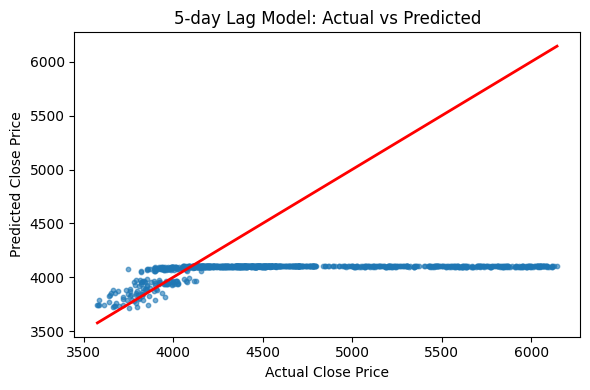

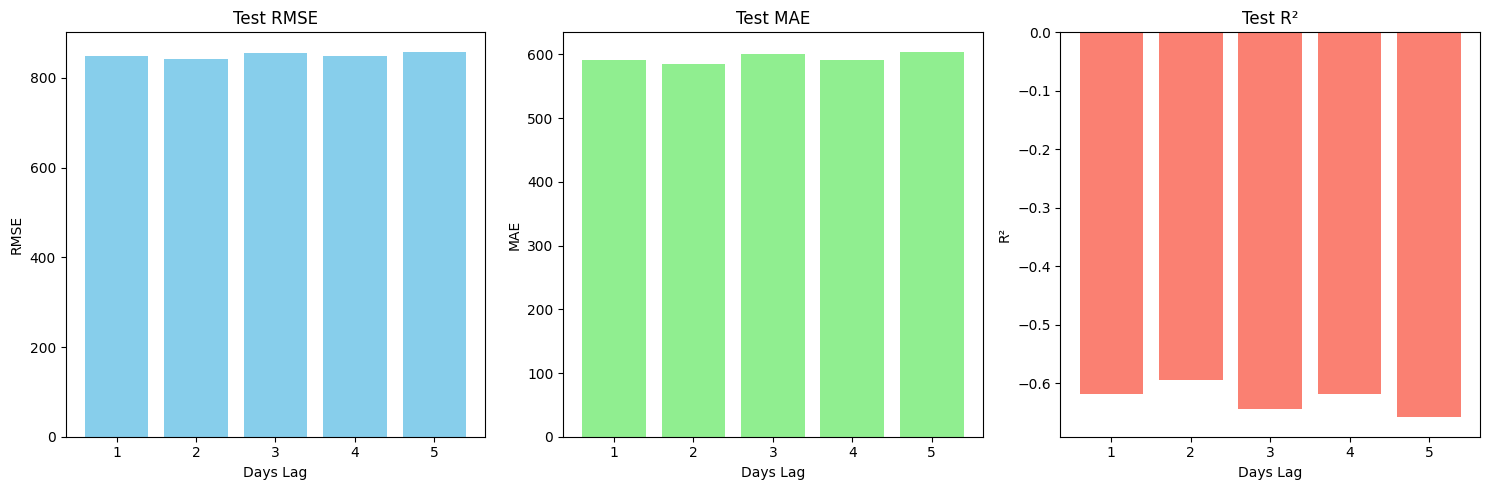

In [9]:
# Visualization: Actual vs Predicted for the 5-day model
# Find the results for the 5-day model to get y_test and y_pred
five_day_results = None
for res in results:
    if res['days'] == 5:
        # Re-run the 5-day model training and prediction to get y_test and y_pred
        df_i = df.copy()
        days = 5
        for lag in range(1, days+1):
            df_i[f'Close_lag{lag}'] = df_i['Close'].shift(lag)
            df_i[f'RSI_lag{lag}'] = df_i['RSI'].shift(lag)
            df_i[f'MACD_lag{lag}'] = df_i['MACD'].shift(lag)
            df_i[f'MA7_lag{lag}'] = df_i['MA7'].shift(lag)
            df_i[f'MA21_lag{lag}'] = df_i['MA21'].shift(lag)
        feature_cols = []
        feature_cols += [f'Close_lag{lag}' for lag in range(1, days+1)]
        feature_cols += [f'RSI_lag{lag}'   for lag in range(1, days+1)]
        feature_cols += [f'MACD_lag{lag}'  for lag in range(1, days+1)]
        feature_cols += [f'MA7_lag{lag}'   for lag in range(1, days+1)]
        feature_cols += [f'MA21_lag{lag}'  for lag in range(1, days+1)]
        feature_cols += [f'{col}_lag1' for col in macro_cols]
        df_i = df_i.dropna(subset=feature_cols + ['Close'])
        X = df_i[feature_cols].values
        y = df_i['Close'].values
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Use the best parameters found for the 5-day model during the grid search
        best_params_5_day = res['best_params']
        best_rf_5_day = RandomForestRegressor(random_state=42, **best_params_5_day)
        best_rf_5_day.fit(X_train, y_train)
        y_pred = best_rf_5_day.predict(X_test)

        break # Exit loop once 5-day results are found


plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('5-day Lag Model: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Bar charts comparing metrics across the 5 models
days = [r['days'] for r in results]
rmse_vals = [r['rmse'] for r in results]
mae_vals  = [r['mae']  for r in results]
r2_vals   = [r['r2']   for r in results]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(days, rmse_vals, color='skyblue')
plt.xlabel('Days Lag')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.xticks(days)

plt.subplot(1, 3, 2)
plt.bar(days, mae_vals, color='lightgreen')
plt.xlabel('Days Lag')
plt.ylabel('MAE')
plt.title('Test MAE')
plt.xticks(days)

plt.subplot(1, 3, 3)
plt.bar(days, r2_vals, color='salmon')
plt.xlabel('Days Lag')
plt.ylabel('R\u00b2')
plt.title('Test R\u00b2')
plt.xticks(days)

plt.tight_layout()
plt.show()